# Predict Sentiment From Movie Reviews Using Deep Learning
[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is a natural language processing problem where text is understood and the underlying intent is predicted.

In this post, you will discover how you can predict the sentiment of movie reviews as either positive or negative in Python using the Keras deep learning library.

After reading this post you will know:

* About the IMDB sentiment analysis problem for natural language processing and how to load it in Keras.
* How to use word embedding in Keras for natural language problems.
* How to develop and evaluate a multi-layer perception model for the IMDB problem.
* How to develop a one-dimensional convolutional neural network model for the IMDB problem.

Let’s get started.

## IMDB Movie Review Sentiment Problem Description
The dataset is the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) often referred to as the IMDB dataset.

The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly polar moving reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.

The data was collected by Stanford researchers and was used in a [2011 paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) [PDF] where a split of 50/50 of the data was used for training and test. An accuracy of 88.89% was achieved.

The data was also used as the basis for a Kaggle competition titled “[Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)” in late 2014 to early 2015. Accuracy was achieved above 97% with winners achieving 99%.

## Load the IMDB Dataset With Keras
Keras provides access to the [IMDB dataset built-in](https://keras.io/datasets/).

The keras.datasets.imdb.load_data() allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

The words have been replaced by integers that indicate the absolute popularity of the word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.

Calling imdb.load_data() the first time will download the IMDB dataset to your computer and store it in your home directory under ~/.keras/datasets/imdb.pkl as a 32 megabyte file.

Usefully, the imdb.load_data() provides additional arguments including the number of top words to load (where words with a lower integer are marked as zero in the returned data), the number of top words to skip (to avoid the “the”‘s) and the maximum length of reviews to support.

Let’s load the dataset and calculate some properties of it. We will start off by loading some libraries and loading the entire IMDB dataset as a training dataset.

In [1]:
import numpy
from keras.datasets import imdb
from matplotlib import pyplot
# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

Using TensorFlow backend.


17473536/17464789 [==============================] - 11s 1us/step


Next we can display the shape of the training dataset.

In [2]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


Running this snippet, we can see that there are 50,000 records. We can also print the unique class values.

In [3]:
# Summarize number of classes
print("Classes: ")
print(numpy.unique(y))

Classes: 
[0 1]


We can see that it is a binary classification problem for good and bad sentiment in the review. Next we can get an idea of the total number of unique words in the dataset.

In [4]:
# Summarize number of words
print("Number of words: ")
print(len(numpy.unique(numpy.hstack(X))))

Number of words: 
88585


Interestingly, we can see that there are just under 100,000 words across the entire dataset. Finally, we can get an idea of the average review length.

Review length: 
Mean 234.76 words (172.911495)


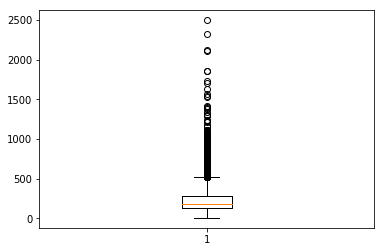

In [5]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

We can see that the average review has just under 300 words with a standard deviation of just over 200 words. Looking a box and whisker plot for the review lengths in words, we can probably see an exponential distribution that we can probably cover the mass of the distribution with a clipped length of 400 to 500 words.

## Word Embeddings
A recent breakthrough in the field of natural language processing is called [word embedding](https://en.wikipedia.org/wiki/Word_embedding).

This is a technique where words are encoded as real-valued vectors in a high-dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Discrete words are mapped to vectors of continuous numbers. This is useful when working with natural language problems with neural networks and deep learning models are we require numbers as input.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an [Embedding layer](https://keras.io/layers/embeddings/).

The layer takes arguments that define the mapping including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value that will be seen as an integer). The layer also allows you to specify the dimensionality for each word vector, called the output dimension.

We would like to use a word embedding representation for the IMDB dataset.

Let’s say that we are only interested in the first 5,000 most used words in the dataset. Therefore our vocabulary size will be 5,000. We can choose to use a 32-dimension vector to represent each word. Finally, we may choose to cap the maximum review length at 500 words, truncating reviews longer than that and padding reviews shorter than that with 0 values.

* We would load the IMDB dataset as follows
* We would then use the Keras utility to truncate or pad the dataset to a length of 500 for each observation using the sequence.pad_sequences() function.
* Finally, later on, the first layer of our model would be an word embedding layer created using the Embedding class

The output of this first layer would be a matrix with the size 32×500 for a given review training or test pattern in integer format.

Now that we know how to load the IMDB dataset in Keras and how to use a word embedding representation for it, let’s develop and evaluate some models.

## Simple Multi-Layer Perceptron Model for the IMDB Dataset
We can start off by developing a simple multi-layer perceptron model with a single hidden layer.

The word embedding representation is a true innovation and we will demonstrate what would have been considered world class results in 2011 with a relatively simple neural network.

Let’s start off by importing the classes and functions required for this model and initializing the random number generator to a constant value to ensure we can easily reproduce the results.

In [9]:
# MLP for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we will load the IMDB dataset. We will simplify the dataset as discussed during the section on word embeddings. Only the top 5,000 words will be loaded.

We will also use a 50%/50% split of the dataset into training and test. This is a good standard split methodology.

In [10]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

We will bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews.

In [11]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Now we can create our model. We will use an Embedding layer as the input layer, setting the vocabulary to 5,000, the word vector size to 32 dimensions and the input_length to 500. The output of this first layer will be a 32×500 sized matrix as discussed in the previous section.

We will flatten the Embedded layers output to one dimension, then use one dense hidden layer of 250 units with a rectifier activation function. The output layer has one neuron and will use a sigmoid activation to output values of 0 and 1 as predictions.

The model uses logarithmic loss and is optimized using the efficient ADAM optimization procedure.

In [12]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


We can fit the model and use the test set as validation while training. This model overfits very quickly so we will use very few training epochs, in this case just 2.

There is a lot of data so we will use a batch size of 128. After the model is trained, we evaluate its accuracy on the test dataset.

In [13]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 37s - loss: 0.5079 - acc: 0.7120 - val_loss: 0.3199 - val_acc: 0.8609
Epoch 2/2
 - 37s - loss: 0.1904 - acc: 0.9275 - val_loss: 0.3004 - val_acc: 0.8732
Accuracy: 87.32%


Running this example fits the model and summarizes the estimated performance. We can see that this very simple model achieves a score of nearly 87.32% which is in the neighborhood of the original paper, with very little effort.

I’m sure we can do better if we trained this network, perhaps using a larger embedding and adding more hidden layers. Let’s try a different network type.

## One-Dimensional Convolutional Neural Network Model for the IMDB Dataset
Convolutional neural networks were designed to honor the spatial structure in image data whilst being robust to the position and orientation of learned objects in the scene.

This same principle can be used on sequences, such as the one-dimensional sequence of words in a movie review. The same properties that make the CNN model attractive for learning to recognize objects in images can help to learn structure in paragraphs of words, namely the techniques invariance to the specific position of features.

Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.

Again, let’s import the classes and functions needed for this example and initialize our random number generator to a constant value so that we can easily reproduce results.

In [14]:
# CNN for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

We can also load and prepare our IMDB dataset as we did before.

In [15]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# pad dataset to a maximum review length in words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

We can now define our convolutional neural network model. This time, after the Embedding input layer, we insert a Conv1D layer. This convolutional layer has 32 feature maps and reads embedded word representations 3 vector elements of the word embedding at a time.

The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [16]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
_________________________________________________________________


We also fit the network the same as before.

In [17]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 44s - loss: 0.4808 - acc: 0.7364 - val_loss: 0.2831 - val_acc: 0.8828
Epoch 2/2
 - 51s - loss: 0.2241 - acc: 0.9116 - val_loss: 0.2795 - val_acc: 0.8840
Accuracy: 88.40%


Running the example, we are first presented with a summary of the network structure. We can see our convolutional layer preserves the dimensionality of our Embedding input layer of 32-dimensional input with a maximum of 500 words. The pooling layer compresses this representation by halving it.

Running the example offers a small but welcome improvement over the neural network model above with an accuracy of nearly 88.40%.

Again, there is a lot of opportunity for further optimization, such as the use of deeper and/or larger convolutional layers. One interesting idea is to set the max pooling layer to use an input length of 500. This would compress each feature map to a single 32 length vector and may boost performance.

## Summary
In this post, you discovered the IMDB sentiment analysis dataset for natural language processing.

You learned how to develop deep learning models for sentiment analysis including:

* How to load and review the IMDB dataset within Keras.
* How to develop a large neural network model for sentiment analysis.
* How to develop a one-dimensional convolutional neural network model for sentiment analysis.